**Action1: 交通流量预测**

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


**读取数据**

In [2]:
path = 'data/jetrail/'
raw = pd.read_csv(path+'train.csv')

In [3]:
#数据处理
data = raw[['Datetime', 'Count']]
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%d-%m-%Y %H:%M")

# 按天聚合
data['Datetime'] = data['Datetime'].apply(lambda x: x.date())
train_data = data.groupby('Datetime').agg({'Count':'sum'})

C:\Users\luoyh\anaconda3\envs\bi_learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\luoyh\anaconda3\envs\bi_learning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


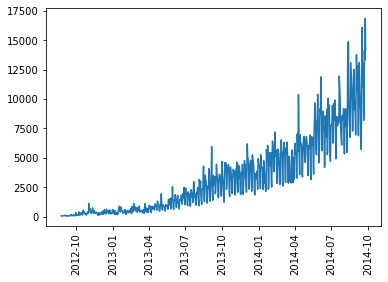

In [4]:
# 数据探索
plt.plot(train_data)
plt.xticks(rotation=90)
plt.show()

In [5]:
# 改名以满足Prophet的输入要求
train_data.reset_index(level=0, inplace=True)
train_data.rename(columns={'Datetime':'ds', 'Count':'y'}, inplace=True)

In [6]:
# 采用Prophet模型
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1)
# 拟合模型
model.fit(train_data)

# 预测未来7个月，213天
future = model.make_future_dataframe(periods=213)

# 预测数据集
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


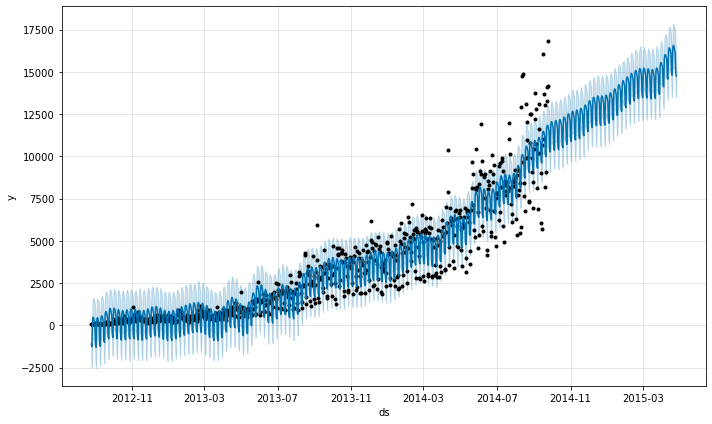

In [7]:
model.plot(forecast)
plt.show()

**加入节假日信息**

In [8]:
# 采用Prophet模型
model_holiday = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1)
model_holiday.add_country_holidays(country_name='US')
# 拟合模型
model_holiday.fit(train_data)

# 预测未来7个月，213天
future = model_holiday.make_future_dataframe(periods=213)

# 预测数据集
forecast = model_holiday.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


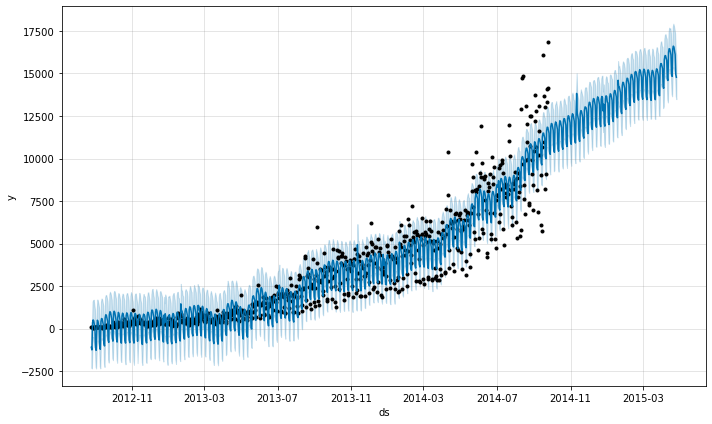

In [9]:
model.plot(forecast)
plt.show()

**各部分可视化**

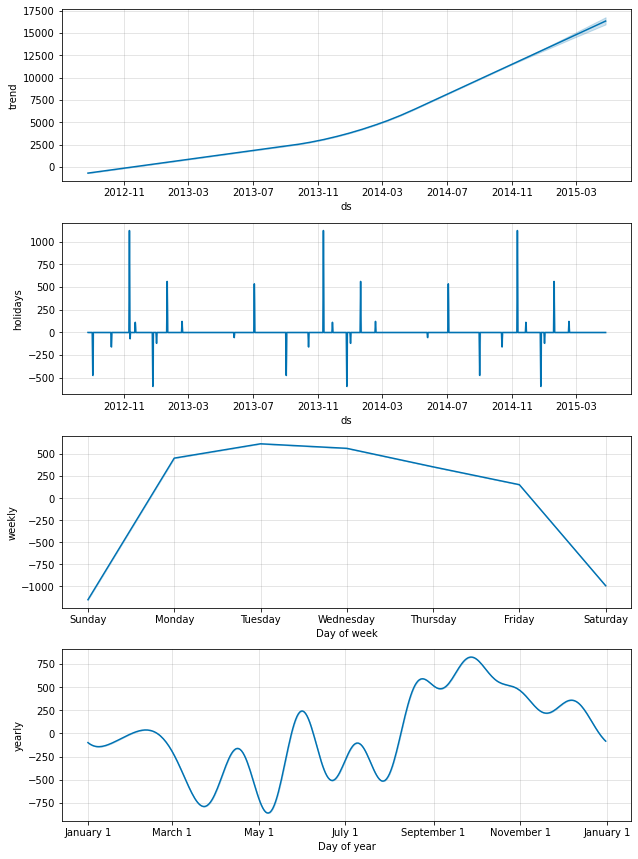

In [10]:
model_holiday.plot_components(forecast)
plt.show()

1. 从星期为周期的趋势可以看出周末两天流量最小，周中流量较大，其中周一最大。和直觉吻合。
2. 从节假日信息可以看出，Veterans Day（11.11）和New Year's Day（1.1）出行的流量较大。
3. 趋势在增长，乘高铁出行的人数在增多，或者高铁数量在增多。

In [11]:
# 显示节假日信息
model_holiday.train_holiday_names

0                 New Year's Day
1      New Year's Day (Observed)
2     Martin Luther King Jr. Day
3          Washington's Birthday
4                   Memorial Day
5               Independence Day
6                      Labor Day
7                   Columbus Day
8                   Veterans Day
9        Veterans Day (Observed)
10                  Thanksgiving
11                 Christmas Day
dtype: object

**Action2:资金流入流出预测**

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

**数据读取**

In [13]:
path = 'data/Purchase Redemption Data/'
data = pd.read_csv(path+'user_balance_table.csv', parse_dates=['report_date'])

In [14]:
# 按天聚合
total_balance = data.groupby('report_date').agg({'total_purchase_amt':'sum', 'total_redeem_amt':'sum'})
# 由于2014年3月份附近有明显拐点，所以只用4月之后的数据进行训练
total_balance = total_balance[total_balance.index>'2014-04-01']

In [15]:
# 划分购买和赎回
purchase = total_balance[['total_purchase_amt']]
redeem = total_balance[['total_redeem_amt']]

**用ARMA模型进行预测， 由于4月之后数据是比较平稳的**

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings
warnings.filterwarnings('ignore')
'''purchase'''
ps = range(1, 8)
qs = range(1, 7)
parameters = list(product(ps, qs))
best_aic = float('inf')
for p, q in parameters:
    try:
        # 选择合适的p，q
        model_purchase = ARIMA(purchase, order=(p,0,q)).fit()
    except ValueError:
        print(f'参数错误：p={p}, q={q}')
        continue
    if model_purchase.aic < best_aic:
        best_aic = model_purchase.aic
        best_model_purchase = model_purchase
#对购买进行预测
purchase_predict = best_model_purchase.predict('2014-09-01', '2014-09-30', typ='levels')
best_model_purchase.aic

5875.992332765463

In [28]:
'''redeem'''
ps = range(1, 8)
qs = range(1, 7)
parameters = list(product(ps, qs))
best_aic = float('inf')
for p, q in parameters:
    try:
        # 选择合适的p，q
        model_redeem = ARIMA(redeem, order=(p,0,q)).fit()
    except ValueError:
        print(f'参数错误：p={p}, q={q}')
        continue
    if model_redeem.aic < best_aic:
        best_aic = model_redeem.aic
        best_model_redeem = model_redeem
#对购买进行预测
redeem_predict = best_model_redeem.predict('2014-09-01', '2014-09-30', typ='levels')
best_model_redeem.aic

5933.734282918522

In [29]:
result = pd.DataFrame()
result['report_date'] = purchase_predict.index
result['purchase'] = purchase_predict.values
result['redeem'] = redeem_predict.values

In [30]:
result['report_date'] = result['report_date'].apply(lambda x: str(x.date()).replace('-', ''))
result.to_csv('tsa_base.csv', header=None, index=None)

**Prophet模型**

In [11]:
# 改名以满足Prophet的输入要求
purchase.reset_index(level=0, inplace=True)
purchase.rename(columns={'report_date':'ds', 'total_purchase_amt':'y'}, inplace=True)
redeem.reset_index(level=0, inplace=True)
redeem.rename(columns={'report_date':'ds', 'total_redeem_amt':'y'}, inplace=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


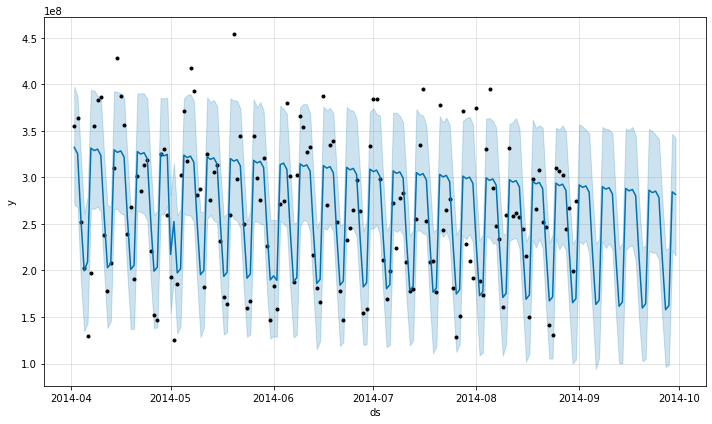

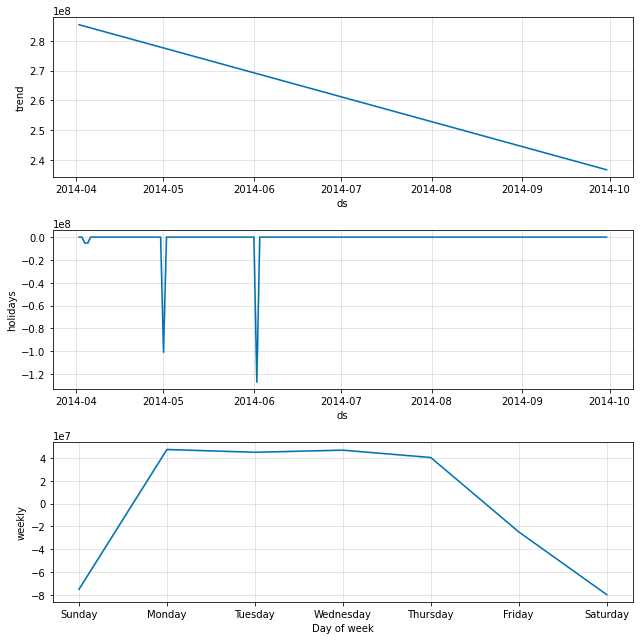

In [24]:
from fbprophet import Prophet
'''purchase'''
# 采用Prophet模型
purchase_model = Prophet(seasonality_prior_scale=0.1)
purchase_model.add_country_holidays(country_name='CN')
# 拟合模型
purchase_model.fit(purchase)

# 预测未来1个月，30天
future = purchase_model.make_future_dataframe(periods=30)

# 预测数据集
purchase_predict = purchase_model.predict(future)

purchase_model.plot(purchase_predict)
purchase_model.plot_components(purchase_predict)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


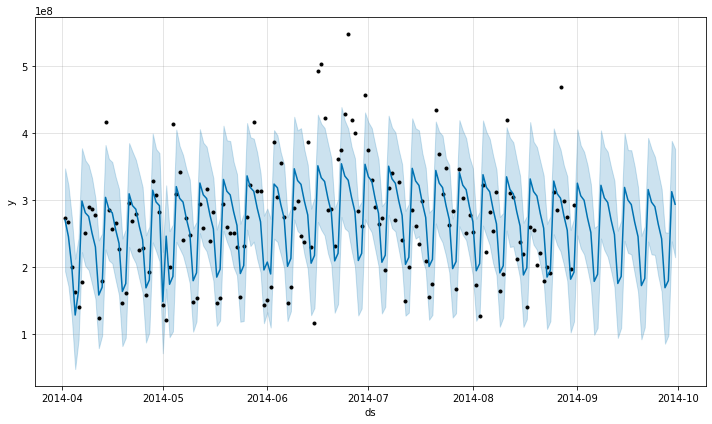

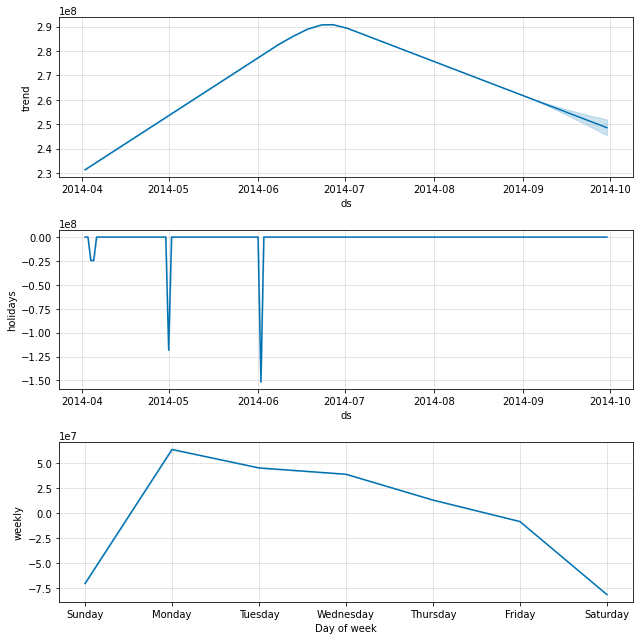

In [23]:
'''redeem'''
# 采用Prophet模型
redeem_model = Prophet(seasonality_prior_scale=0.1)
redeem_model.add_country_holidays(country_name='CN')
# 拟合模型
redeem_model.fit(redeem)

# 预测未来1个月，30天
future = redeem_model.make_future_dataframe(periods=30)

# 预测数据集
redeem_predict = redeem_model.predict(future)

redeem_model.plot(redeem_predict)
redeem_model.plot_components(redeem_predict)
plt.show()

In [ ]:
result = pd.DataFrame()
result['report_date'] = purchase_predict['ds'][-30:]
result['purchase'] = purchase_predict['yhat'][-30:]
result['redeem'] = redeem_predict['yhat'][-30:]

In [26]:
result['report_date'] = result['report_date'].apply(lambda x: str(x.date()).replace('-', ''))
result.to_csv('prophet_base_recent.csv', header=None, index=None)

**prophet模型效果更好**